# CQPS simulation
> - Everything normalised by electric charge $2e$
> - Time will be in units of ns (and correspondigly GHz)
> - [**See this presentation**](https://quantum-optics-ride.gitlab.io/duality-presentation/)

<img src="./support-files/cqps_annotated_diagram.svg"/>

1. The equations for the voltage across the system (Charge on the island ($n\times{(2e)}$, blue) is broken up between the charge on CQPS ($n_{\text{cqps}}\times{(2e)}$, red) and on the capacitance ($n_{c}\times{(2e)}$, green))

| Term                                                                                                                                  | Explanation                                          |
|---------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------|
| \begin{equation*}V(t) = \color{blue}{L{(2e)}{\frac{d^{2}n}{dt^{2}}}} + \color{blue}{R{(2e)}{\frac{dn}{dt}}} + \color{red}{V_s\sin(2\pi n_{\text{cqps}}(t)}\end{equation*} | Dual circuit to the JJ                               |
| \begin{equation*}V(t) = V_b + V_{mw}\cos(2\pi{f_{mw}}{t})\end{equation*}                                                                                            | Irradiating system with rf and applying bias voltage |
| \begin{equation*}\color{red}{V_s\sin(2\pi n_{\text{cqps}}(t))} = \color{green}{\frac{{(2e)}}{C}n_{c}(t) + {(2e)}r\frac{dn_x}{dt}}\end{equation*}                          | Equalising voltage on the "island"                   |
| \begin{equation*}n(t) = n_{\text{cqps}}(t) + n_{c}(t)\end{equation*}                                                                                                | Charge on the "island"                               |

2. Converted to first order by introducing $\color{red}{i/\color{grey}{(2e)} = \dot{n}}$
3. The numerical simulation will begin with initial, $i=0$, $n_{cqps}=0$, and use derivatives to compute next value (t-dependent terms highlighted in red for clarity):

\begin{equation}
\begin{aligned}
 \color{grey}{\frac{1}{2e}}\color{red}{\dot{i}} & = \color{grey}{\frac{1}{2e}}\frac{V_b}{L} + \color{grey}{\frac{1}{2e}}\frac{V_{mw}}{L}\cos{\left( 2\pi f_{mw} \color{red}{t}\right)} - \color{grey}{\frac{1}{2e}}\frac{R}{L}\color{red}{i} - \color{grey}{\frac{1}{2e}}\frac{V_{s}}{L{(2e)}}\sin{\left( 2\pi\color{red}{n_{\text{cqps}}} \right)}\\
 \color{red}{\dot{n}_{\text{cqps}}} & = \frac{1}{1 + \frac{2\pi{C}V_{s}}{\color{grey}{2e}}\cos{\left( 2\pi\color{red}{n_{\text{cqps}}} \right)}}\color{grey}{\frac{1}{2e}}\color{red}{i}
\end{aligned}
\end{equation}

4. using kernel $\mathbb{K}$ that will take a time, and a state vector to return the derivatives for the next step.

\begin{equation}
\mathbb{kernel}\left( t, \begin{bmatrix}
    i\\n_{\text{cqps}}
  \end{bmatrix} \right)  \Rightarrow \begin{bmatrix}
    \dot{i}(i, n_{\text{cqps}}, t)\\
    \dot{n}_{cqps}(n_{i, \text{cqps}})
  \end{bmatrix}
\end{equation}

In [57]:
%matplotlib notebook
import logging
from typing import List
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("support-files/qubit.mplstyle")
from matplotlib import cm
from IPython.display import display
import ipywidgets
from scipy import integrate
import scipy.special as spl 
from pyprind import ProgBar
import plotly.graph_objects as go
import plotly.figure_factory as ff
from scipy.spatial import Delaunay

h = 6.64 * 10**(-34)
eCharge = 1.6 * 10 ** (-19)
TWO_PI = 2 * np.pi
PHI0 = h / (2 * eCharge)
PHI0_over_2PI = PHI0 / TWO_PI
Q_0 = 2 * eCharge

uA = 10**(-6)
uV = 10**(-6)
GHz = 10**9
ns = 10**(-9)
uH = 10**(-6)
fF = 10**(-15)

def average_in_range(x_input: List[float], y_input: List[float], x_start: float, x_end: float) -> float:
    """
    Takes average of y_input ([1,2,3,4,5....]) by specifying:
    - x_start
    - x_end 
    use values from y_input that correspond to the selected x_input scope
    """

    x_start_idx = np.searchsorted(x_input, x_start)
    x_end_idx = np.searchsorted(x_input, x_end)
    return np.mean(y_input[x_start_idx : x_end_idx])

# Slimmed simulations with no capacitance
> Setting $r=0$, $C=0$

\begin{equation}
\begin{aligned}
 \color{red}{\dot{i}(i, n_{\text{cqps}}, t)} & = \frac{V_b}{L} + \frac{V_{mw}}{L}\cos{\left( 2\pi f_{mw} \color{red}{t}\right)} - \frac{R}{L}\color{red}{i} - \frac{V_{s}}{L}\sin{\left( 2\pi\color{red}{n_{\text{cqps}}} \right)}\\
 \color{red}{\dot{n}_{\text{cqps}}(i, n_{\text{cqps}}, t)} & = \color{grey}{\frac{1}{2e}}\color{red}{i}
\end{aligned}
\end{equation}


## Current evolution

In [16]:
STATE_INITIAL = [0, 0]
CURRENT_IDX = 0

def slimmed_cqps_kernel(t: float, state_vector: List[float],
                   Vb_over_L: float, Vmw_over_L: float, omega_mw: float,
                   Vs_over_L: float, R_over_L
    ) -> List[float]:
    """Kernel evalautes the derivitives for each components of the state_vector to make the next step:
            x_99 = x_98 + dx_98/dt*Δt
    - Evaluate the various fractions, Vb/L in order to speed up performace.
    - state_vector must have the order: (i, ncqps)
    """
    
    (i, ncqps) = state_vector
    
    di_dt = (
        Vb_over_L
        + (Vmw_over_L * np.cos(omega_mw * t))
        - R_over_L * i
        - Vs_over_L * np.sin(TWO_PI * ncqps)
    )
    dncqps_dt = i / Q_0

    return [di_dt, dncqps_dt]

<IPython.core.display.Javascript object>


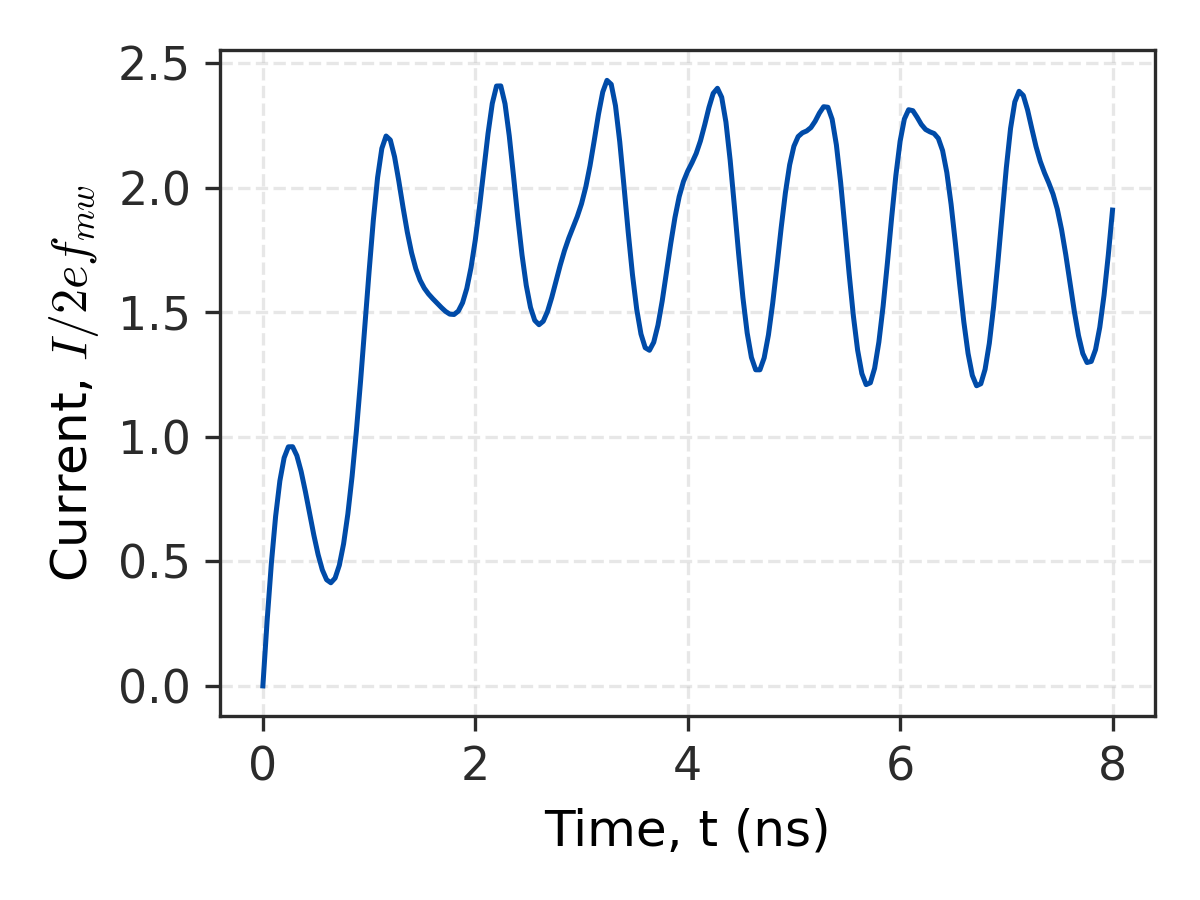

In [17]:
Vb = 12*uV
Vmw = 10*uV
fmw = 1*GHz
Vs = 6*uV
R = 20_000
L = 10*uH

t_end = 8*ns
t_points = 201

# Initial simulation and plot
t_list = np.linspace(0, t_end, t_points) 
simulation = integrate.odeint(
    func=slimmed_cqps_kernel,
    y0=STATE_INITIAL,
    t=t_list,
    args=(Vb / L, Vmw / L, fmw * TWO_PI, Vs / L, R / L),
    tfirst=True,
)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
simulation_graph, = ax.plot(t_list / ns, simulation[:, CURRENT_IDX] / Q_0 / fmw)
ax.set_xlabel("Time, t (ns)", fontsize=12)
ax.set_ylabel("Current, $I/2ef_{mw}$", fontsize=12)
plt.tight_layout()

# Interactive plot
def update(Vb: float, Vmw: float, fmw: float, Vs: float, R: float, L: float):
    Vb = Vb*uV
    Vmw = Vmw*uV
    fmw = fmw*GHz
    Vs = Vs*uV
    L = L*uH
    
    simulation = integrate.odeint(
        func=slimmed_cqps_kernel,
        y0=STATE_INITIAL,
        t=t_list,
        args=(Vb / L, Vmw / L, fmw * TWO_PI, Vs / L, R / L),
    tfirst=True,
    )
    simulation_graph.set_ydata(simulation[:, CURRENT_IDX] / Q_0 / fmw)

In [4]:
CONTINUOUS_UPDATE = True
Vb_widget = ipywidgets.FloatSlider(
    min=0, max=50, step=0.1,
    description="$V_{bias}$ (uV)", value=Vb/uV,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Vmw_widget = ipywidgets.FloatSlider(
    min=0, max=50, step=0.1,
    description="$V_{mw}$ (uV)", value=Vmw/uV,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Vmw_widget.style.handle_color = 'red'
fmw_widget = ipywidgets.FloatSlider(
    min=0, max=10, step=0.1,
    description="$f_{mw}$ (GHz)", value=fmw/GHz,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
fmw_widget.style.handle_color = 'red'
Vs_widget = ipywidgets.FloatSlider(
    min=0, max=100,
    description=r"$V_s$ (uV)", value=Vs/uV,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
R_widget = ipywidgets.FloatSlider(
    min=0, max=10**5,
    description="R (Ohms)", value=R,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
L_widget = ipywidgets.FloatSlider(
    min=0, max=100,
    description="L (uH)", value=L/uH,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(3, 2)
ui[0,0] = Vb_widget
ui[1,0] = Vmw_widget
ui[2,0] = fmw_widget
ui[0,1] = R_widget
ui[1,1] = L_widget
ui[2,1] = Vs_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "Vb": Vb_widget,
        "Vmw": Vmw_widget,
        "fmw": fmw_widget,
        "Vs": Vs_widget,
        "R": R_widget,
        "L": L_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=12.0, description='$V_{bias}$ (uV)', layout=Layout(grid_area='widge…

Output()

## I-V curve
Plotting $V_\text{bias}$ vs the average resulting current, $I/2ef_{mw}$ for an I-V curve

In [46]:
def average_current_slimmed_cqps_kernel(t_list: List[float], t_start: float, t_end: float,
                                        Vb: float, Vmw: float, fmw: float, Vs: float, R: float, L: float):
    """
    Kernel evaluates the average current in the system for times t_list
    """
    
    normalised_current = integrate.odeint(
        func=slimmed_cqps_kernel,
        y0=STATE_INITIAL,
        t=t_list,
        args=(Vb / L, Vmw / L, fmw * TWO_PI, Vs / L, R / L),
        tfirst=True,
    )[:, CURRENT_IDX] / Q_0 / fmw

    return average_in_range(t_list, normalised_current, t_start, t_end)

<IPython.core.display.Javascript object>


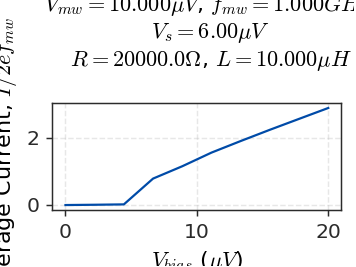

In [9]:
Vmw = 10*uV
fmw = 1*GHz
Vs = 6*uV
R = 20_000
L = 10*uH

t_start = 0
t_end = 8*ns
t_points = 201

vb_start = 0
vb_end = 20*uV
vb_points = 10

# Deriving parameters and running simulation
# Simulations must always start from t=0, otherwise you will simply be shifting the response when changing t_start
t_list = np.linspace(0, t_end, t_points)
vb_list = np.linspace(vb_start, vb_end, vb_points)
i_list = [
    average_current_slimmed_cqps_kernel(
        t_list, t_start, t_end,
        vb, Vmw, fmw, Vs, R, L)
    for vb in vb_list
]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
simulation_graph, = ax.plot(vb_list / uV, i_list)
ax.set_xlabel("$V_{bias}$ ($\mu{V}$)", fontsize=12)
ax.set_ylabel("Average Current, $I/2ef_{mw}$", fontsize=12)
ax.set_title(
    f"""
    $V_{{mw}}={Vmw/uV:.3f}\mu{{V}}$, $f_{{mw}}={fmw/GHz:.3f}GHz$, 
    $V_s={Vs/uV:.2f}\mu{{V}}$
    $R={R}\Omega$, $L={L/uH:.3f}\mu{{H}}$
    """,
    fontsize=12)
plt.tight_layout()

# Interactive plot


def update(Vmw: float, fmw: float, Vs: float, R: float, L: float,
           #            t_start: float, t_end: float
           ):
    Vmw = Vmw*uV
    fmw = fmw*GHz
    Vs = Vs*uV
    L = L*uH

    i_list = [
        average_current_slimmed_cqps_kernel(
            t_list, t_start, t_end,
            vb, Vmw, fmw, Vs, R, L)
        for vb in vb_list
    ]
    simulation_graph.set_ydata(i_list)
    ax.set_title(
        f"""
    $V_{{mw}}={Vmw/uV:.3f}\mu{{V}}$, $f_{{mw}}={fmw/GHz:.3f}GHz$, 
    $V_s={Vs/uV:.2f}\mu{{V}}$
    $R={R}\Omega$, $L={L/uH:.3f}\mu{{H}}$
    """,
        fontsize=12)

In [10]:
CONTINUOUS_UPDATE = True
Vmw_widget = ipywidgets.FloatSlider(
    min=0, max=50, step=0.1,
    description="$V_{mw}$ (uV)", value=Vmw/uV,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Vmw_widget.style.handle_color = 'red'
fmw_widget = ipywidgets.FloatSlider(
    min=0, max=10, step=0.1,
    description="$f_{mw}$ (GHz)", value=fmw/GHz,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
fmw_widget.style.handle_color = 'red'
Vs_widget = ipywidgets.FloatSlider(
    min=0, max=100,
    description=r"$V_s$ (uV)", value=Vs/uV,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
R_widget = ipywidgets.FloatSlider(
    min=0, max=10**5,
    description="R (Ohms)", value=R,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
L_widget = ipywidgets.FloatSlider(
    min=0, max=100,
    description="L (uH)", value=L/uH,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(3, 2)
ui[1,0] = Vmw_widget
ui[2,0] = fmw_widget
ui[0,1] = R_widget
ui[1,1] = L_widget
ui[2,1] = Vs_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "Vmw": Vmw_widget,
        "fmw": fmw_widget,
        "Vs": Vs_widget,
        "R": R_widget,
        "L": L_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=10.0, description='$V_{mw}$ (uV)', layout=Layout(grid_area='widget0…

Output()

## 3D plot: current vs $V_{mw}$ vs $V_{bias}$

In [11]:
fmw = 1*GHz
Vs = 5*uV
R = 10_000
L = 2*uH

t_start = 0
t_end = 8*ns
t_points = 201

vb_start = 0
vb_end = 20*uV
vb_points = 41

vmw_start = 0
vmw_end = 100*uV
vmw_points = 101

# Deriving parameters and running simulation
# Simulations must always start from t=0, otherwise you will simply be shifting the response when changing t_start
t_list = np.linspace(0, t_end, t_points)
vb_list = np.linspace(vb_start, vb_end, vb_points)
vmw_list = np.linspace(vmw_start, vmw_end, vmw_points)
i_average_mesh = np.empty((vb_points, vmw_points))

progress_bar = ProgBar(vb_points * vmw_points, bar_char="█")
for Vb_idx, Vb in enumerate(vb_list):
    for Vmw_idx, Vmw in enumerate(vmw_list):
        i_average_mesh[Vb_idx][Vmw_idx] = (
            average_current_slimmed_cqps_kernel(
                t_list, t_start, t_end,
                Vb, Vmw, fmw, Vs, R, L)
        )
        progress_bar.update()
        
# Arrays for differnet plotting
vb_mesh, vmw_mesh = np.meshgrid(vb_list, vmw_list)
vb_mesh_flat = vb_mesh.flatten()
vmw_mesh_flat = vmw_mesh.flatten()
i_average_mesh_flat = i_average_mesh.T.flatten()

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:04


In [18]:
# Triangular with matplotlib
fig = plt.figure(figsize=(5, 5))
ax3d = fig.add_subplot(projection='3d')
ax3d.plot_trisurf(vb_mesh_flat/uV,
                  vmw_mesh_flat/uV,
                  i_average_mesh_flat,
                  cmap='copper',
                  antialiased=True
)
ax3d.set_xlabel("$V_{bias}$ ($\mu{V}$)", fontsize=12)
ax3d.set_ylabel("$V_{mw}$ ($\mu{V}$)", fontsize=12)
ax3d.set_zlabel("$I/2ef_{mw}$", fontsize=8)
ax3d.set_title(
        f"""
    $f_{{mw}}={fmw/GHz:.3f}GHz$, 
    $V_s={Vs/uV:.2f}\mu{{V}}$
    $R={R}\Omega$, $L={L/uH:.3f}\mu{{H}}$
    """, fontsize=10)
ax3d.view_init(elev=40,azim=-127)
plt.tight_layout()

<IPython.core.display.Javascript object>

In [19]:
# Suerface with matplotlib
fig = plt.figure(figsize=(5, 5))
ax3d = fig.add_subplot(projection='3d')
ax3d.plot_surface(vb_mesh/ uV,
                  vmw_mesh/ uV,
                  i_average_mesh.T,
                  cmap='copper',
                  antialiased=True
)
ax3d.set_xlabel("$V_{bias}$ ($\mu{V}$)", fontsize=12)
ax3d.set_ylabel("$V_{mw}$ ($\mu{V}$)", fontsize=12)
ax3d.set_zlabel("$I/2ef_{mw}$", fontsize=8)
ax3d.set_title(
        f"""
    $f_{{mw}}={fmw/GHz:.3f}GHz$, 
    $V_s={Vs/uV:.2f}\mu{{V}}$
    $R={R}\Omega$, $L={L/uH:.3f}\mu{{H}}$
    """, fontsize=10)
ax3d.view_init(elev=40,azim=-127)

<IPython.core.display.Javascript object>

In [16]:
# Surface with plotly
surface_plot = go.Surface(
    y=vb_list/uV,
    x=vmw_list/uV,
    z=i_average_mesh)
surface_plot_layout = go.Layout(
    title_text=f"$f_{{mw}}={fmw/GHz:.3f}GHz, V_s={Vs/uV:.2f}\mu{{V}}, R={R}\Omega, L={L/uH:.3f}\mu{{H}}$",
    width=1000,
    height=1000,
    margin_pad=8,
    scene=dict(
        camera = {
                'eye': {'x': 1.25, 'y': -1.25, 'z': 1.25},
        },
        yaxis={
            "tickfont": {"size": 15},
            "title": {
                "text": "Vb (μV)",
                "font": {
                        "size": 40
                }
            }
        },
        xaxis={
            "tickfont": {"size": 15},
            "title": {
                "text": "Vmw (μV)",
                "font": {
                        "size": 40
                }
            }
        },
        zaxis={
            "tickfont": {"size": 15},
            "title": {
                "text": "I/2efmw",
                "font": {
                        "size": 40,
                }
            }
        }
    )
)
fig = go.Figure(
    data=[surface_plot],
    layout=surface_plot_layout
)
fig.show()

In [17]:
# Triangular with plotly
simplices = Delaunay(
    np.vstack(
        [vb_mesh_flat, vmw_mesh_flat]
    ).T
).simplices

fig = ff.create_trisurf(
    x=vb_mesh_flat/uV, y=vmw_mesh_flat/uV, z=i_average_mesh_flat,
    simplices=simplices,
    width=1000, 
    height=1000,
)
fig.update_layout(
    title_text=f"$f_{{mw}}={fmw/GHz:.3f}GHz, V_s={Vs/uV:.2f}\mu{{V}}, R={R}\Omega, L={L/uH:.3f}\mu{{H}}$",
    title_font_size=40,
    width=1000,
    height=1000,
    margin_pad=8,
    scene=dict(
        camera = {
                'eye': {'x': -1, 'y': -1.25, 'z': 1.25},
        },
        xaxis={
            "tickfont": {"size": 15},
            "title": {
                "text": "Vb (μV)",
                "font": {
                        "size": 40
                }
            }
        },
        yaxis={
            "tickfont": {"size": 15},
            "title": {
                "text": "Vmw (μV)",
                "font": {
                        "size": 40
                }
            }
        },
        zaxis={
            "tickfont": {"size": 15},
            "title": {
                "text": "I/2efmw",
                "font": {
                        "size": 40,
                }
            }
        }
    )
)
fig.show()

In [ ]:
def slimmed_kernel_average(
                   Vb: float, Vmw: float, f_mw: float,
                   Vs: float, R: float, integration_range: List[float, float]
    ) -> List[float]:
    """
    Integrates output of slimmed kernel
    """

    (i, ncqps) = state_vector
    
    di_dt = (
        Vb_over_L
        + (Vmw_over_L * np.cos(omega_mw * t))
        - R_over_L * integration_range
        - Vs_over_L * np.sin(TWO_PI * ncqps)
    )
    dncqps_dt = i / Q_0

    return [di_dt, dncqps_dt]

# Complete simulation

In [ ]:
uV = 10**(-6)
GHz = 1
ns = 1
uH = 10**(-6)
fF = 10**(-15)

def slimmed_kernel(t: float, state_vector: List[float],
                   V_b_over_L: float, V_mw_over_L: float, omega_mw: float,
                   V_s: float, R_over_L: float, L: float, C: float,
    ) -> List[float]:
    """Requires even more pre-computed parameters"""
    
#     print(V_b_over_L)
#     print(V_mw_over_L)
#     print(omega_mw)
#     print(V_s)
#     print(R_over_L)
#     print(L)
#     print(C)
    
    (i, ncqps) = state_vector
    di_dt = (
        V_b_over_L
        + (V_mw_over_L * np.cos(omega_mw * t))
        - i * R_over_L
        - V_s / L * np.sin(TWO_PI * ncqps)
    )
    dncqps_dt = i / (
        1 + TWO_PI * C * V_s * np.cos(TWO_PI * ncqps)
    )
    return [di_dt, dncqps_dt]


def kernel(t: float, state_vector: List[float],
           V_b: float, V_mw: float, f_mw: float,
           V_s: float, R: float, L: float, C: float) -> List[float]:
    (i, ncqps) = state_vector
    di_dt = (
        (V_b / L)
        + (V_mw / L * np.cos(TWO_PI * f_mw * t))
        - R * i / L
        - V_s / L * np.sin(TWO_PI * ncqps)
    )
    dncqps_dt = i / (
        1 + TWO_PI * C * V_s * np.cos(TWO_PI * ncqps)
    )
    return [di_dt, dncqps_dt]

In [ ]:
%%time

V_b = 20*uV
V_mw = 1*uV
f_mw = 2*GHz
V_s = 5*uV
R = 20_000
L = 10*uH
C = 0*fF

t_list = np.linspace(0, 1000, 1001)
state_initial = [0, 0]
simulation = integrate.solve_ivp(
    fun=kernel, 
    t_span=(0, max(t_list)),
    y0=state_initial,
    t_eval=t_list,
    args=(V_b / Q_0, V_mw / Q_0, f_mw, V_s / Q_0, R, L, C),
    method="RK45",
)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t_list, simulation["y"][0])
ax.set_xlabel("Time, t (ns)", fontsize=12)
ax.set_ylabel("Current, I (A)", fontsize=12)

plt.show()

# Bessel Functions
In a simplified picture, where the rf will only bias the CQPS, 

In [86]:
t_list = np.linspace(0,10,500)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
for i in range(1, 5):
    ax.plot(t_list, spl.jv(i, t_list), label=f"$J_{i}$")
ax.set_xlabel("arg", fontsize=12)
ax.set_ylabel("Amplitude", fontsize=12)
plt.tight_layout()
def update(bessel_selection):
    plt.cla()
    for i in range(bessel_selection[0] + 1, bessel_selection[1]):
        ax.plot(t_list, spl.jv(i, t_list), label=f"$J_{i}$")
ax.legend()
# plt.savefig("output/bessel_plot.png")

bessel_selection_widget = ipywidgets.IntRangeSlider(
    value=[0, 1],
    min=0,
    max=10,
    step=1,
    description='Bessel selection',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=ipywidgets.Layout(width='90%'),
)
ui = ipywidgets.VBox([bessel_selection_widget])

<IPython.core.display.Javascript object>

In [87]:
out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "bessel_selection": bessel_selection_widget,
    }
)

display(ui, out)

Output()

# JJ simulation (dual system)
<img src="./support-files/jj_annotated.svg" width="500"/>

\begin{equation}
  \begin{aligned}
    I(t) & = \color{\green}{\frac{d}{dt}\left[ CV \right]} + \color{blue}{\frac{V}{R}} + \color{red}{\text{JJ current}}\\
  \end{aligned}
\end{equation}

\begin{equation}
 I(t) = \color{gray}{\left( \frac{\hbar}{(2e)} \right)}\color{blue}{C\frac{d^2\phi}{dt^{2}}} + \color{gray}{\left( \frac{\hbar}{(2e)} \right)}\color{blue}{\frac{1}{R}\frac{d\phi}{dt}} + \color{red}{I_c\sin{\phi}}
\end{equation}



## Constant current is applied
> Phase will evolve in a way to maintain this current

\begin{equation}
 I = \frac{1}{R}\frac{\Phi_0}{2\pi}\frac{d\phi}{dt} + I_c\sin(\varphi)
\end{equation}

> - $I>I_c$ in which case phase will change and voltage will generated across JJ
> - $I<I_c$ in which case phase will take a constant value

In [2]:
def model_v1(phi, t, I, Ic, R_scaled):
    return (I - Ic * np.sin(phi)) * R_scaled

phi_init = 0
t_list = np.linspace(0, 20)

<IPython.core.display.Javascript object>


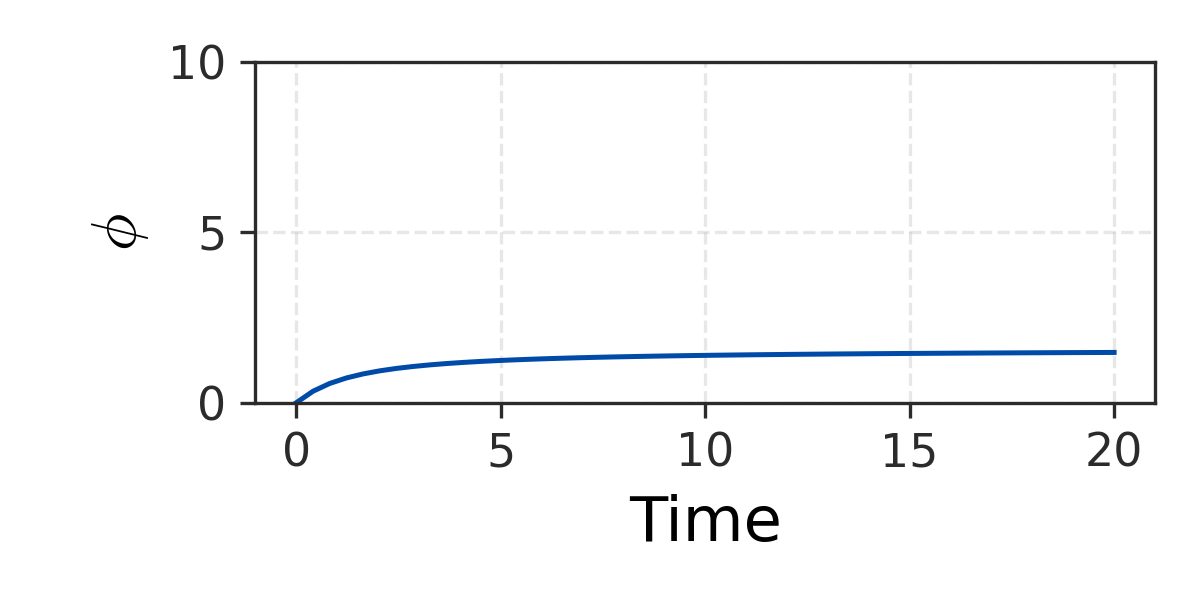

In [3]:
# Initial simulation
I = 0.5
Ic = 0.5
R_scaled = 2
phi_list = integrate.odeint(model_v1, phi_init, t_list, args=(I, Ic, R_scaled))

# Initial plot
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
graph, = ax.plot(t_list, phi_list)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("$\phi$", fontsize=15)
ax.set_ylim([0, 10])
plt.tight_layout()

# Interactive plot
def update(I: float, Ic: float, R_scaled: float):
    phi_list = integrate.odeint(model_v1, phi_init, t_list, args=(I, Ic, R_scaled))
    graph.set_ydata(phi_list)

In [4]:
I_widget = ipywidgets.FloatSlider(
    min=0, max=1, step=0.01,
    description="Bias current, I", value=I,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
Ic_widget = ipywidgets.FloatSlider(
    min=0, max=1, step=0.01,
    description="Critical current, Ic", value=Ic,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
R_widget = ipywidgets.FloatSlider(
    min=0, max=2,
    description="Resistance, R", value=R_scaled,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
ui = ipywidgets.VBox([I_widget, Ic_widget, R_widget])

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "I": I_widget,
        "Ic": Ic_widget,
        "R_scaled": R_widget}
)
display(ui, out)

Output()

## RF is applied, but only to the JJ
- $\color{gray}{\left( \frac{\hbar}{(2e)} \right)}\color{blue}{\frac{1}{R}\frac{d\phi}{dt}} = \color{blue}{\frac{V_b}{R}}$
- $\color{gray}{\left( \frac{\hbar}{(2e)} \right)}\color{blue}{C\frac{d^2\phi}{dt^{2}}} = 0$
- $\color{red}{V = V_b + V_{mw}\cos(2\pi{f_{mw}}{t})} \Rightarrow \color{red}{\phi = \phi_0 + \color{gray}{\frac{(2e)}{\hbar}}V_bt + \color{gray}{\frac{(2e)}{\hbar}}\frac{V_{mw}}{2\pi{f_{mw}}}\sin{\left( 2\pi{f_{mw}}{t} \right)}}$

\begin{equation}
  I(t) = \color{blue}{\frac{V_b}{R}} + \color{red}{I_c\Im{\left[ \exp{\left( i(\phi_0 + \color{gray}{\frac{(2e)}{\hbar}}V_bt + \color{gray}{\frac{(2e)}{\hbar}}\frac{V_{mw}}{2\pi{f_{mw}}}\sin{\left( 2\pi{f_{mw}}{t} \right)}) \right)} \right]}}.
\end{equation}

Direct evaluation of the current evolution

In [36]:
PHASE_INITIAL = 0

def model_v2(
    t: float, 
    Vb_over_R: float,
    Ic: float, 
    Vb_over_PHI0_over_2PI: float, 
    Vmw_over_PHI0_over_2PI, 
    wmw: float) -> float:
    """
    Returns current at a given time
    """
    
    return (
        Vb_over_R
        + Ic * np.sin(
#             PHASE_INITIAL + 
            Vb_over_PHI0_over_2PI * t
            + Vmw_over_PHI0_over_2PI * np.sin(wmw * t) / wmw)
    )

<IPython.core.display.Javascript object>


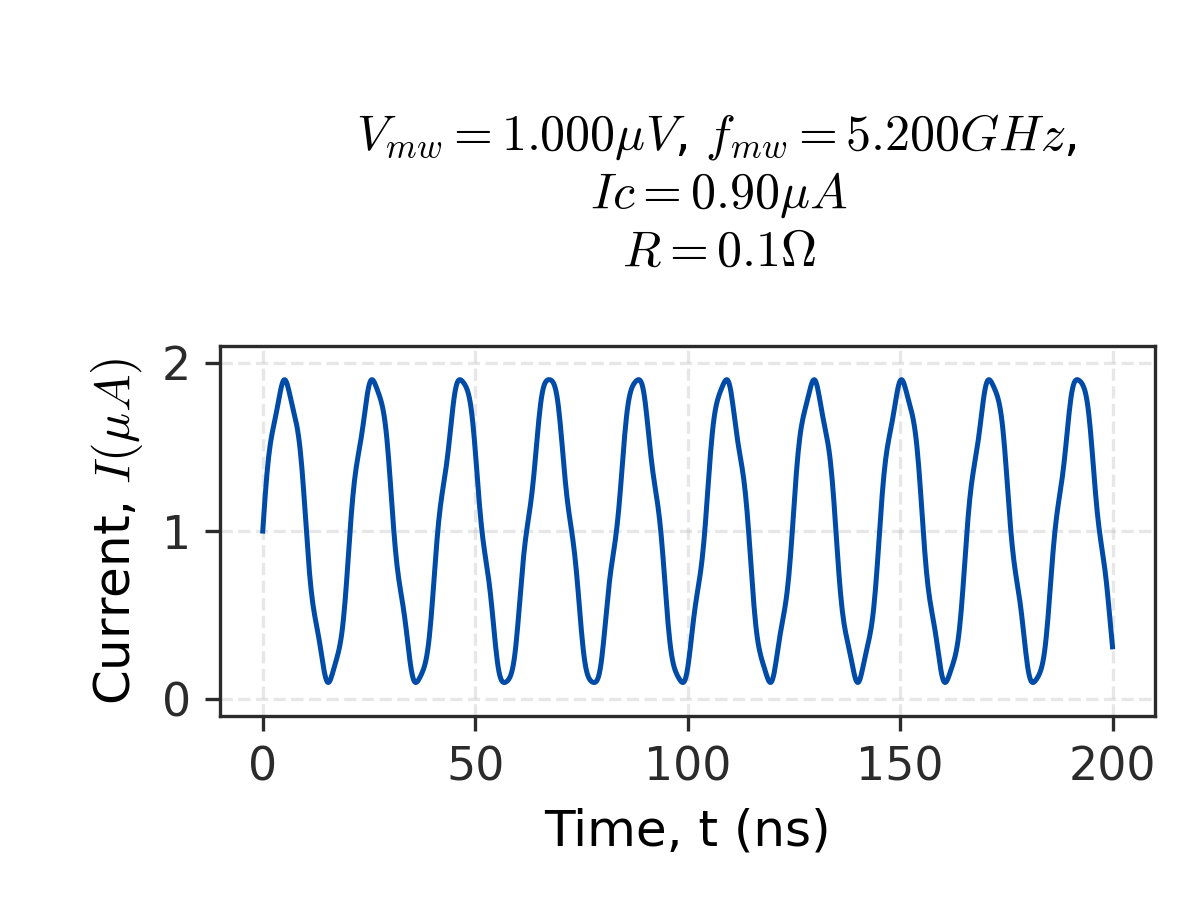

In [146]:
Vb = 0.1*uV
R = 0.1
Ic = 1*uA
Vmw = 1*uV
fmw = 0.1*GHz

t_end = 200*ns
t_points = 1001

# Derived parameters

# Initial simulation and plot
t_list = np.linspace(0, t_end, t_points) 
current_simulation = partial(model_v2, 
                     Vb_over_R=Vb/R,
                     Ic=Ic,
                     Vb_over_PHI0_over_2PI=Vb/PHI0_over_2PI,
                     Vmw_over_PHI0_over_2PI=Vmw/PHI0_over_2PI,
                     wmw = TWO_PI*fmw
                    )(t_list)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
simulation_graph, = ax.plot(t_list / ns, current_simulation / uA)
ax.set_xlabel("Time, t (ns)", fontsize=12)
ax.set_ylabel("Current, $I (\mu{A})$", fontsize=12)
ax.set_title(
    f"""
    $V_{{mw}}={Vmw/uV:.3f}\mu{{V}}$, $f_{{mw}}={fmw/GHz:.3f}GHz$, 
    $Ic={Ic/uA:.2f}\mu{{A}}$
    $R={R}\Omega$
    """,
    fontsize=12)
plt.tight_layout()

# Interactive plot
def update(Vb: float, R: float, Ic: float, Vmw: float, fmw: float):
    Vb = Vb*uV
    Vmw = Vmw*uV
    fmw = fmw*GHz
    Ic = Ic*uA
    print(Ic)
    
    current_simulation = partial(model_v2, 
                     Vb_over_R=Vb/R,
                     Ic=Ic,
                     Vb_over_PHI0_over_2PI=Vb/PHI0_over_2PI,
                     Vmw_over_PHI0_over_2PI=Vmw/PHI0_over_2PI,
                     wmw = TWO_PI*fmw
                    )(t_list)
    ax.set_title(
    f"""
    $V_{{mw}}={Vmw/uV:.3f}\mu{{V}}$, $f_{{mw}}={fmw/GHz:.3f}GHz$, 
    $Ic={Ic/uA:.2f}\mu{{A}}$
    $R={R}\Omega$
    """,
    fontsize=12)
    simulation_graph.set_ydata(current_simulation / uA)

In [148]:
CONTINUOUS_UPDATE = True
Vmw_widget = ipywidgets.FloatSlider(
    min=0, max=50, step=0.1,
    description="$V_{mw}$ (uV)", value=Vmw/uV,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Vmw_widget.style.handle_color = 'red'
fmw_widget = ipywidgets.FloatSlider(
    min=0.1, max=10, step=0.1,
    description="$f_{mw}$ (GHz)", value=fmw/GHz,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
fmw_widget.style.handle_color = 'red'
Vb_widget = ipywidgets.FloatSlider(
    min=0, max=2, step=0.01,
    description=r"$V_b$ (uV)", value=Vb/uV,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
R_widget = ipywidgets.FloatSlider(
    min=0.1, step=0.1,
#     max=10**3,
    max=1,
    description="R (Ohms)", value=R,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Ic_widget = ipywidgets.FloatSlider(
    min=0, max=2,
    description="$I_c (\mu{A})$", value=Ic/uA,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(3, 2)
ui[1,0] = Vmw_widget
ui[2,0] = fmw_widget
ui[0,:] = Vb_widget
ui[1,1] = R_widget
ui[2,1] = Ic_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "Vmw": Vmw_widget,
        "fmw": fmw_widget,
        "Vb": Vb_widget,
        "R": R_widget,
        "Ic": Ic_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=1.0, description='$V_{mw}$ (uV)', layout=Layout(grid_area='widget00…

Output()

## I-V curve
Plotting $V_\text{bias}$ vs the average resulting current, $I$ for an I-V curve

In [68]:
def average_current_model_v2(
    t_list: List[float], t_start: float, t_end: float,
    Vb: float, R: float, Ic: float, Vmw: float, fmw: float):
    """
    Kernel evaluates the average current in the system for times t_list
    """
    
    current = partial(model_v2, 
                     Vb_over_R=Vb/R,
                     Ic=Ic,
                     Vb_over_PHI0_over_2PI=Vb/PHI0_over_2PI,
                     Vmw_over_PHI0_over_2PI=Vmw/PHI0_over_2PI,
                     wmw = TWO_PI*fmw
                    )(t_list)

    return average_in_range(t_list, current, t_start, t_end)

<IPython.core.display.Javascript object>


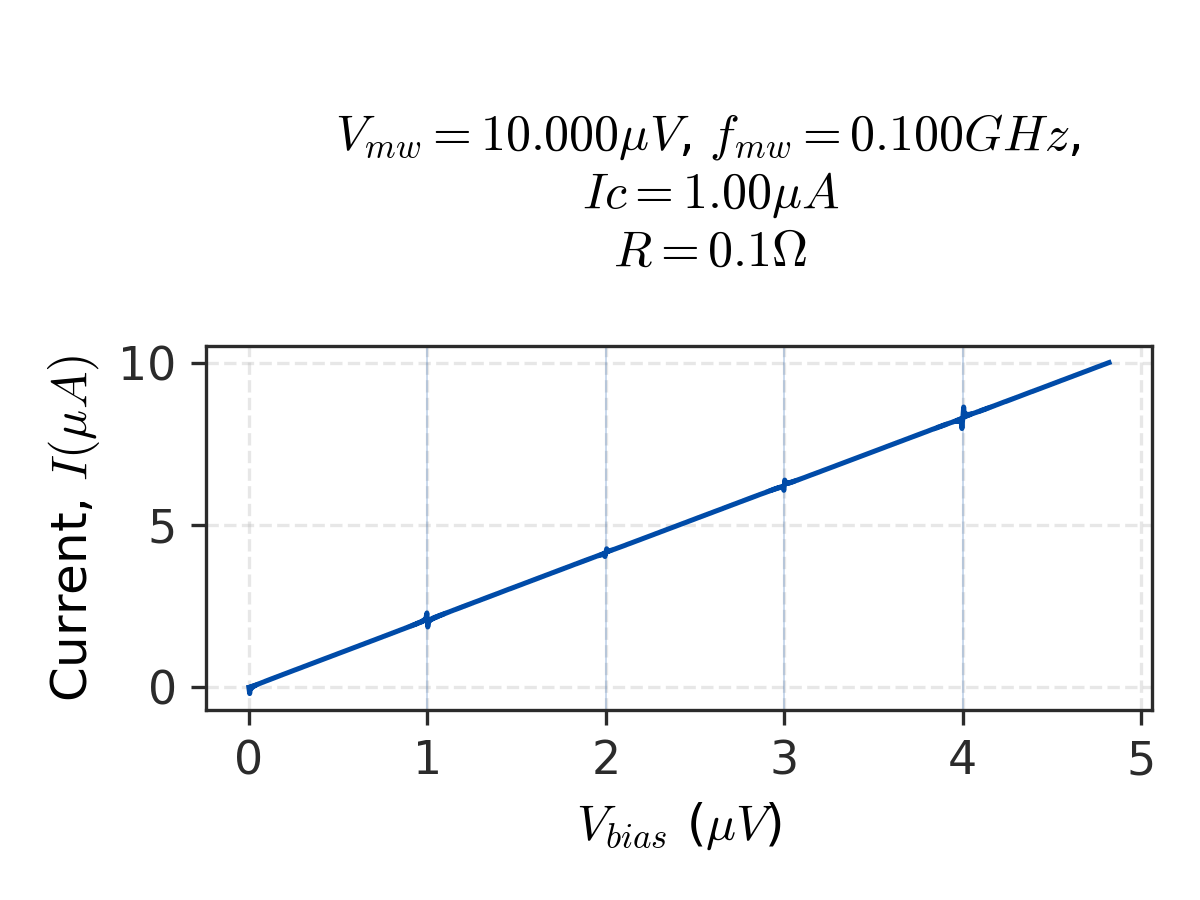

In [168]:
R = 0.1
Ic = 1*uA
Vmw = 10*uV
fmw = 0.1*GHz

t_start = 0
t_end = 1000*ns
t_points = 1001

vb_start = 0*uV
vb_end = 1*uV
vb_points = 1001

# Deriving parameters and running simulation
# Simulations must always start from t=0, otherwise you will simply be shifting the response when changing t_start
expected_step = [k 
                 *1
#                  * h * fmw / Q_0 / uV 
                 for k in range(1,5)]
t_list = np.linspace(0, t_end, t_points)
vb_list = np.linspace(vb_start, vb_end, vb_points)
current_list = np.array([
    average_current_model_v2(
        t_list, t_start, t_end,
        vb, R, Ic, Vmw, fmw)
    for vb in vb_list
])

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
simulation_graph, = ax.plot(vb_list * Q_0 / h / fmw, current_list/uA)
for i in expected_step:
    ax.axvline(x=i, linewidth=0.1)
    
ax.set_xlabel("$V_{bias}$ ($\mu{V}$)", fontsize=12)
ax.set_ylabel("Current, $I (\mu{A})$", fontsize=12)
ax.set_title(
    f"""
    $V_{{mw}}={Vmw/uV:.3f}\mu{{V}}$, $f_{{mw}}={fmw/GHz:.3f}GHz$, 
    $Ic={Ic/uA:.2f}\mu{{A}}$
    $R={R}\Omega$
    """,
    fontsize=12)
plt.tight_layout()

def update(R: float, Ic: float, Vmw: float, fmw: float):
    Vmw = Vmw*uV
    fmw = fmw*GHz
    Ic=Ic*uA
    
    current_list = np.array([
        average_current_model_v2(
            t_list, t_start, t_end,
            vb*uV, R, Ic, Vmw, fmw)
        for vb in vb_list
    ])
    simulation_graph.set_ydata(current_list/uA)
    ax.set_title(
    f"""
    $V_{{mw}}={Vmw/uV:.3f}\mu{{V}}$, $f_{{mw}}={fmw/GHz:.3f}GHz$, 
    $Ic={Ic/uA:.2f}\mu{{A}}$
    $R={R}\Omega$
    """,
    fontsize=12)    

In [131]:
CONTINUOUS_UPDATE = True
Vmw_widget = ipywidgets.FloatSlider(
    min=0, max=50, step=0.1,
    description="$V_{mw}$ (uV)", value=Vmw/uV,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Vmw_widget.style.handle_color = 'red'
fmw_widget = ipywidgets.FloatSlider(
    min=0, max=10, step=0.1,
    description="$f_{mw}$ (GHz)", value=fmw/GHz,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
fmw_widget.style.handle_color = 'red'
R_widget = ipywidgets.FloatSlider(
    min=0.1, step=0.1,
#     max=10**3,
    max=10,
    description="R (Ohms)", value=R,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Ic_widget = ipywidgets.FloatSlider(
    min=0, max=2,
    description="$I_c (\mu{A})$", value=Ic/uA,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)


ui = ipywidgets.GridspecLayout(3, 2)
ui[1,0] = Vmw_widget
ui[2,0] = fmw_widget
ui[1,1] = R_widget
ui[2,1] = Ic_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "Vmw": Vmw_widget,
        "fmw": fmw_widget,
        "R": R_widget,
        "Ic": Ic_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=1.0, description='$V_{mw}$ (uV)', layout=Layout(grid_area='widget00…

Output()

In [129]:
50*10**(-6) / (1.2*10**(-3))

0.041666666666666664